# CSE 676: Deep Learning Final Project Checkpoint
## Topic: Improving Drug Discovery by Inclusion of Graph-Level Representation in Graph Neural Networks.

By: Param Patel (50560141) \
UBIT: paramnar

Dataset: ToxCast

## 1. Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.Draw import rdMolDraw2D

In [2]:
df=pd.read_csv('toxcast_data.csv')
df.head(20)

,smiles,ACEA_T47D_80hr_Negative,ACEA_T47D_80hr_Positive,APR_HepG2_CellCycleArrest_24h_dn,APR_HepG2_CellCycleArrest_24h_up,APR_HepG2_CellCycleArrest_72h_dn,APR_HepG2_CellLoss_24h_dn,APR_HepG2_CellLoss_72h_dn,APR_HepG2_MicrotubuleCSK_24h_dn,APR_HepG2_MicrotubuleCSK_24h_up,...,Tanguay_ZF_120hpf_OTIC_up,Tanguay_ZF_120hpf_PE_up,Tanguay_ZF_120hpf_PFIN_up,Tanguay_ZF_120hpf_PIG_up,Tanguay_ZF_120hpf_SNOU_up,Tanguay_ZF_120hpf_SOMI_up,Tanguay_ZF_120hpf_SWIM_up,Tanguay_ZF_120hpf_TRUN_up,Tanguay_ZF_120hpf_TR_up,Tanguay_ZF_120hpf_YSE_up
0,[O-][N+](=O)C1=CC=C(Cl)C=C1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C[SiH](C)O[Si](C)(C)O[Si](C)(C)O[SiH](C)C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CN1CCN(CC1)C(=O)C1CCCCC1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NC1=CC=C(C=C1)[N+]([O-])=O,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,OC1=CC=C(C=C1)[N+]([O-])=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,CC1=CC(=O)NO1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,COC1=CC=C(C=C1)C(C)=O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,CN(C)C1=CC=C(C=O)C=C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,[O-][N+](=O)C1=CC=C(CBr)C=C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,[O-][N+](=O)C1=CC=C(CCl)C=C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8597 entries, 0 to 8596
Columns: 618 entries, smiles to Tanguay_ZF_120hpf_YSE_up
dtypes: float64(617), object(1)
memory usage: 40.5+ MB


In [4]:
df.columns

Index(['smiles', 'ACEA_T47D_80hr_Negative', 'ACEA_T47D_80hr_Positive',
       'APR_HepG2_CellCycleArrest_24h_dn', 'APR_HepG2_CellCycleArrest_24h_up',
       'APR_HepG2_CellCycleArrest_72h_dn', 'APR_HepG2_CellLoss_24h_dn',
       'APR_HepG2_CellLoss_72h_dn', 'APR_HepG2_MicrotubuleCSK_24h_dn',
       'APR_HepG2_MicrotubuleCSK_24h_up',
       ...
       'Tanguay_ZF_120hpf_OTIC_up', 'Tanguay_ZF_120hpf_PE_up',
       'Tanguay_ZF_120hpf_PFIN_up', 'Tanguay_ZF_120hpf_PIG_up',
       'Tanguay_ZF_120hpf_SNOU_up', 'Tanguay_ZF_120hpf_SOMI_up',
       'Tanguay_ZF_120hpf_SWIM_up', 'Tanguay_ZF_120hpf_TRUN_up',
       'Tanguay_ZF_120hpf_TR_up', 'Tanguay_ZF_120hpf_YSE_up'],
      dtype='object', length=618)

### Observation:
After reading the paper, the source of the dataset and looking at the dataset itself, the conclusion is that this is a multiclass binary classification problem with only one input variable that being smiles.

## 2.Data Preprocessing

In [5]:
df.head(3)

,smiles,ACEA_T47D_80hr_Negative,ACEA_T47D_80hr_Positive,APR_HepG2_CellCycleArrest_24h_dn,APR_HepG2_CellCycleArrest_24h_up,APR_HepG2_CellCycleArrest_72h_dn,APR_HepG2_CellLoss_24h_dn,APR_HepG2_CellLoss_72h_dn,APR_HepG2_MicrotubuleCSK_24h_dn,APR_HepG2_MicrotubuleCSK_24h_up,...,Tanguay_ZF_120hpf_OTIC_up,Tanguay_ZF_120hpf_PE_up,Tanguay_ZF_120hpf_PFIN_up,Tanguay_ZF_120hpf_PIG_up,Tanguay_ZF_120hpf_SNOU_up,Tanguay_ZF_120hpf_SOMI_up,Tanguay_ZF_120hpf_SWIM_up,Tanguay_ZF_120hpf_TRUN_up,Tanguay_ZF_120hpf_TR_up,Tanguay_ZF_120hpf_YSE_up
0,[O-][N+](=O)C1=CC=C(Cl)C=C1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C[SiH](C)O[Si](C)(C)O[Si](C)(C)O[SiH](C)C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CN1CCN(CC1)C(=O)C1CCCCC1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
smilesList= df['smiles']
target_df=df.drop(columns=['smiles'])


    Since our work is with Graph Neural Networks, we need to extract features from each molecule at an atomic level as well as at a bond level.

In [7]:
def atomicFeatures(atom):
    return [
        atom.GetAtomicNum(),
        atom.GetDegree(),
        atom.GetFormalCharge(),
        int(atom.GetHybridization()),
        atom.GetIsAromatic()
    ]

def Molecule2Graph(SMILE, targets):
    molecule = Chem.MolFromSmiles(SMILE)
    if molecule is None:
        return None

    atom_features = [atomicFeatures(atom) for atom in molecule.GetAtoms()]
    if len(atom_features) == 0:
        return None
    x = torch.tensor(atom_features, dtype=torch.float)

    edges = [] #Adjacency List
    for bond in molecule.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        # Since we are working with chemical models, it is best to assume an undirected graph.
        edges.append((i, j))
        edges.append((j, i))  

    if len(edges) == 0:
        return None
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()


    y = torch.tensor(targets.values, dtype=torch.float)
    mask = ~torch.isnan(y)
    y[~mask] = 0.0  # Replace NaNs with 0 to allow forward pass

    return Data(x=x, edge_index=edge_index, y=y, mask=mask)


In [8]:
df

,smiles,ACEA_T47D_80hr_Negative,ACEA_T47D_80hr_Positive,APR_HepG2_CellCycleArrest_24h_dn,APR_HepG2_CellCycleArrest_24h_up,APR_HepG2_CellCycleArrest_72h_dn,APR_HepG2_CellLoss_24h_dn,APR_HepG2_CellLoss_72h_dn,APR_HepG2_MicrotubuleCSK_24h_dn,APR_HepG2_MicrotubuleCSK_24h_up,...,Tanguay_ZF_120hpf_OTIC_up,Tanguay_ZF_120hpf_PE_up,Tanguay_ZF_120hpf_PFIN_up,Tanguay_ZF_120hpf_PIG_up,Tanguay_ZF_120hpf_SNOU_up,Tanguay_ZF_120hpf_SOMI_up,Tanguay_ZF_120hpf_SWIM_up,Tanguay_ZF_120hpf_TRUN_up,Tanguay_ZF_120hpf_TR_up,Tanguay_ZF_120hpf_YSE_up
0,[O-][N+](=O)C1=CC=C(Cl)C=C1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C[SiH](C)O[Si](C)(C)O[Si](C)(C)O[SiH](C)C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CN1CCN(CC1)C(=O)C1CCCCC1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NC1=CC=C(C=C1)[N+]([O-])=O,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,OC1=CC=C(C=C1)[N+]([O-])=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8592,[O-]S(=O)(=O)C(F)(F)F.CCCC[N+]1=CC=CC=C1C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8593,F[P-](F)(F)(F)(F)F.CCCC[N+]1=CC=CC=C1C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8594,[O-]S(=O)(=O)C(F)(F)F.CCC[N+]1(C)CCCC1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8595,CCCCCCCCCCCCC1=CC=CC=C1S([O-])(=O)=O.CCCCCCCCC...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
from torch_geometric.loader import DataLoader
import pandas as pd

df = pd.read_csv("toxcast_data.csv")
smiles_col = "smiles"
targets_df = df.drop(columns=[smiles_col])

graphs = []
for i in range(len(df)):
    data = Molecule2Graph(df[smiles_col][i], targets_df.iloc[i])
    if data is not None:
        graphs.append(data)


[23:04:14] Explicit valence for atom # 0 F, 1, is greater than permitted
[23:04:15] Explicit valence for atom # 2 Cl, 1, is greater than permitted
[23:04:15] Explicit valence for atom # 0 Cl, 1, is greater than permitted
[23:04:15] WARNING: not removing hydrogen atom without neighbors
[23:04:15] SMILES Parse Error: syntax error while parsing: FAIL
[23:04:15] SMILES Parse Error: check for mistakes around position 2:
[23:04:15] FAIL
[23:04:15] ~^
[23:04:15] SMILES Parse Error: Failed parsing SMILES 'FAIL' for input: 'FAIL'
[23:04:15] SMILES Parse Error: syntax error while parsing: FAIL
[23:04:15] SMILES Parse Error: check for mistakes around position 2:
[23:04:15] FAIL
[23:04:15] ~^
[23:04:15] SMILES Parse Error: Failed parsing SMILES 'FAIL' for input: 'FAIL'
[23:04:15] SMILES Parse Error: syntax error while parsing: FAIL
[23:04:15] SMILES Parse Error: check for mistakes around position 2:
[23:04:15] FAIL
[23:04:15] ~^
[23:04:15] SMILES Parse Error: Failed parsing SMILES 'FAIL' for input

In [10]:
graphs

[Data(x=[10, 5], edge_index=[2, 20], y=[617], mask=[617]),
 Data(x=[15, 5], edge_index=[2, 28], y=[617], mask=[617]),
 Data(x=[15, 5], edge_index=[2, 32], y=[617], mask=[617]),
 Data(x=[10, 5], edge_index=[2, 20], y=[617], mask=[617]),
 Data(x=[10, 5], edge_index=[2, 20], y=[617], mask=[617]),
 Data(x=[7, 5], edge_index=[2, 14], y=[617], mask=[617]),
 Data(x=[11, 5], edge_index=[2, 22], y=[617], mask=[617]),
 Data(x=[11, 5], edge_index=[2, 22], y=[617], mask=[617]),
 Data(x=[11, 5], edge_index=[2, 22], y=[617], mask=[617]),
 Data(x=[11, 5], edge_index=[2, 22], y=[617], mask=[617]),
 Data(x=[11, 5], edge_index=[2, 22], y=[617], mask=[617]),
 Data(x=[66, 5], edge_index=[2, 144], y=[617], mask=[617]),
 Data(x=[12, 5], edge_index=[2, 24], y=[617], mask=[617]),
 Data(x=[12, 5], edge_index=[2, 24], y=[617], mask=[617]),
 Data(x=[12, 5], edge_index=[2, 24], y=[617], mask=[617]),
 Data(x=[12, 5], edge_index=[2, 24], y=[617], mask=[617]),
 Data(x=[12, 5], edge_index=[2, 24], y=[617], mask=[617]

## Step 3: Data Visualisation

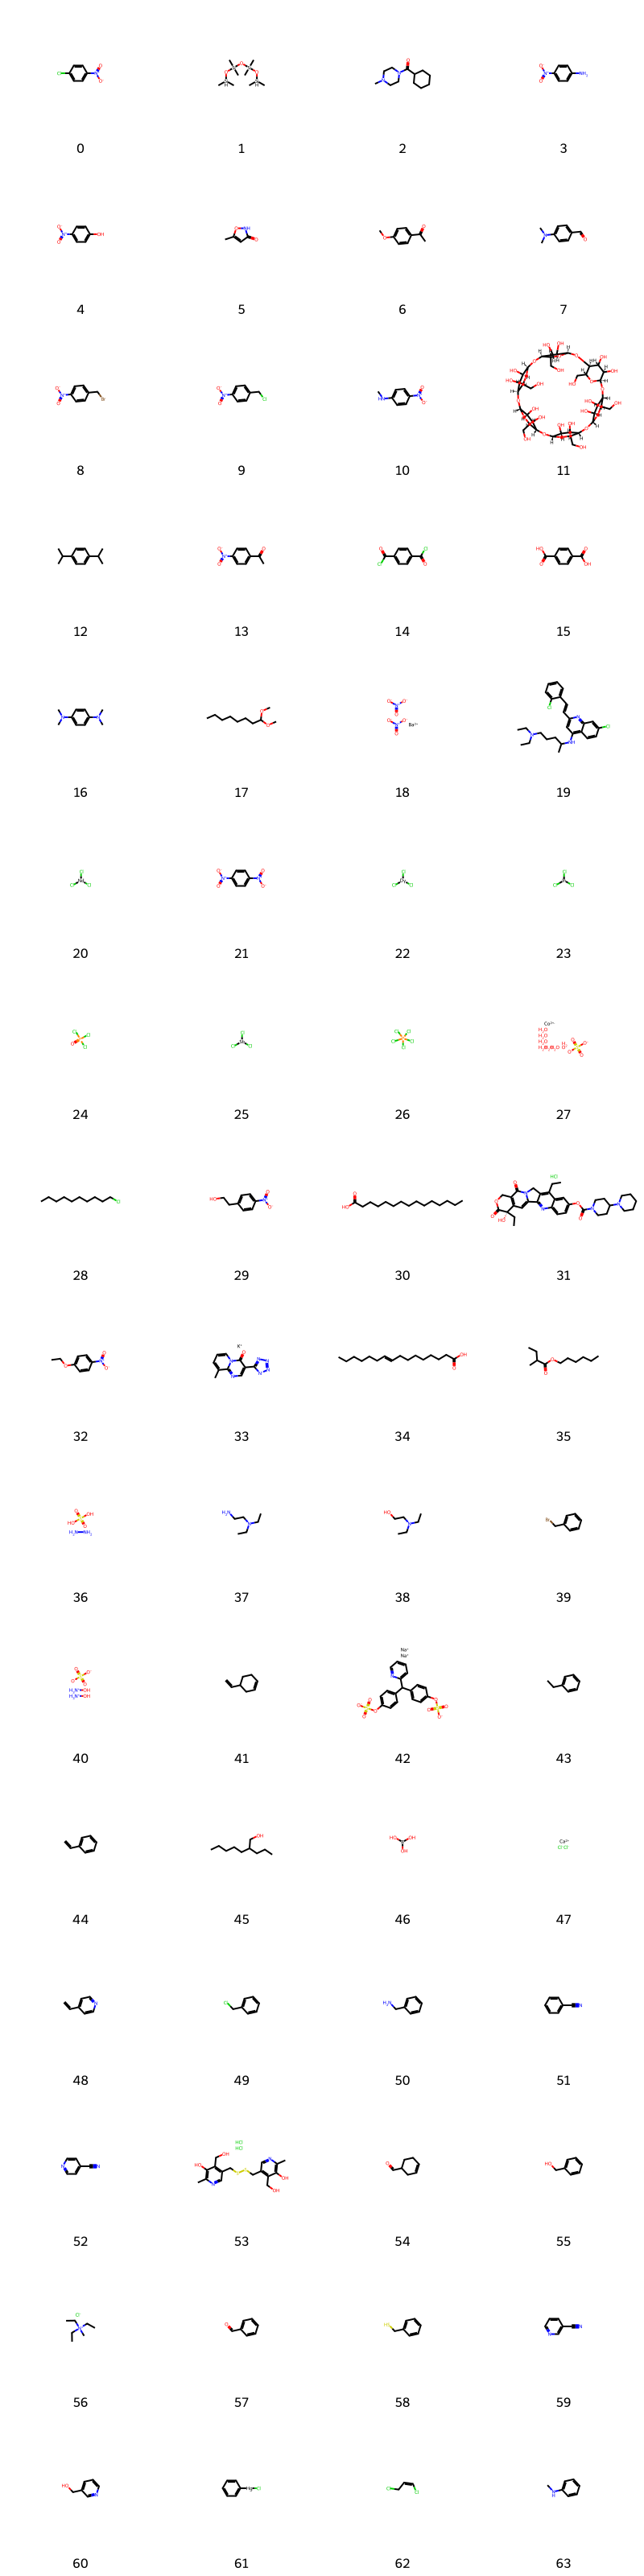

In [11]:



smiles_list = df.iloc[:, 0].tolist()[:64]        
names_list = df.index.astype(str).tolist()[:64]   

mols = [Chem.MolFromSmiles(s) for s in smiles_list]
mols = [mol for mol in mols if mol is not None]

names = names_list[:len(mols)]

image = Draw.MolsToGridImage(
    mols,
    molsPerRow=4,
    subImgSize=(200, 200),
    legends=names,
    maxMols=64
)

image

## Step 4: Creating a Train/Validation/Test Split 
- ratio 70:15:15

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train_graphs, temp_graphs = train_test_split(graphs, test_size=0.30, random_state=42)

In [14]:
val_graphs, test_graphs = train_test_split(temp_graphs, test_size=0.5, random_state=42)

In [15]:
print(f"Train: {len(train_graphs)}")
print(f"Validation: {len(val_graphs)}")
print(f"Test: {len(test_graphs)}")

Train: 5997
Validation: 1285
Test: 1286


## Step 5: DataLoader Creation 

In [16]:
from torch_geometric.loader import DataLoader

batch_size = 42

# DataLoaders
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_graphs, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)


In [17]:
train_loader

# References: 
1. RDKit: Open-source cheminformatics. https://www.rdkit.org
2. https://github.com/ZJULearning/graph_level_drug_discovery
3. @article{DBLP:journals/corr/abs-1709-03741,
  author       = {Junying Li and
                  Deng Cai and
                  Xiaofei He},
  title        = {Learning Graph-Level Representation for Drug Discovery},
  journal      = {CoRR},
  volume       = {abs/1709.03741},
  year         = {2017},
  url          = {http://arxiv.org/abs/1709.03741},
  eprinttype    = {arXiv},
  eprint       = {1709.03741},
  timestamp    = {Wed, 13 Jan 2021 12:32:58 +0100},
  biburl       = {https://dblp.org/rec/journals/corr/abs-1709-03741.bib},
  bibsource    = {dblp computer science bibliography, https://dblp.org}
}